<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/train_vitTiny16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -qq install keras-cv

!pip -qq install pycocotools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 kB 11.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /content/data
#!gdown https://drive.google.com/uc?id=1_IAWexEWpH-ly_JaA5EGfZDp-_3flkN1
!unzip -q /content/drive/MyDrive/Audiodata/ALL_images.zip -d /content/ALL_images/
#!mv "/content/data/Acted Emotional Speech Dynamic Database/" /content/data/aesdd/

In [ ]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
import glob


import seaborn as sns
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, SpatialDropout2D
from keras.layers import MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.callbacks import LearningRateScheduler
import sys
from keras.layers import Layer, Activation, LeakyReLU
import shutil

import keras_cv as kcv
from keras_cv.models import ViTTiny16
from keras_cv.layers import preprocessing

#import wandb
#from wandb.keras import WandbMetricsLogger
#from wandb.keras import WandbEvalCallback

from sklearn.metrics import classification_report, confusion_matrix
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from numpy.random import seed
seed(1)
import tensorflow as tf
print(tf.__version__)

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.
2.12.0


In [5]:
print(tf.config.list_physical_devices())
tf.compat.v1.set_random_seed(1)

from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    #y_pred = np.argmax(y_pred, axis=1)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def loss_f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 1-2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_crossentropy(y_truth, y_pred):
    # Obtain Soft DSC
    dice = loss_f1_m(y_truth, y_pred)
    # Obtain Crossentropy
    crossentropy = K.categorical_crossentropy(y_truth, y_pred)
    crossentropy = K.mean(crossentropy)
    # Return sum
    return dice + crossentropy

def define_model(start_kernels=16, input_shape=(128, 128, 1), pretrained_weights=None):
    from tensorflow.keras import regularizers
    # https://keras.io/api/layers/convolution_layers/convolution1d/
    model = tf.keras.Sequential([
        ############ 1
        Conv2D(start_kernels, kernel_size=5, padding='same', kernel_initializer='he_normal', use_bias=False,
               input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        SpatialDropout2D(0.015),
        MaxPooling2D(pool_size=2),  # <---1
        ############ 2
        Conv2D(start_kernels * 2, kernel_size=5, strides=1, padding='same', kernel_initializer='he_normal',
               use_bias=False, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        SpatialDropout2D(0.015),
        MaxPooling2D(pool_size=2),  # <---2
        ############ 3
        Conv2D(start_kernels * 4, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal',
               use_bias=False,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        SpatialDropout2D(0.015),
        MaxPooling2D(pool_size=2),  # <---3
        ############# 4
        #Conv2D(start_kernels * 8, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal',
        #      use_bias=False),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1),
        #MaxPooling2D(pool_size=2),  # <---4

        ############# 5
        #Conv2D(start_kernels * 8, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal',
        #       use_bias=False),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1),
        #MaxPooling2D(pool_size=2),  # <---5

        ############# fully connected
        Flatten(), #GlobalAveragePooling2D(),
        #Dense(512),
        #LeakyReLU(alpha=0.1),
        #Dense(64,
        #        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        #        bias_regularizer=regularizers.l2(1e-4),
        #        activity_regularizer=regularizers.l2(1e-5)),
        #LeakyReLU(alpha=0.1),
        Dense(32,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)),
        
        LeakyReLU(alpha=0.1),
        Dropout(0.02),
        Dense(7, activation='softmax',
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5))
    ])

    # model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    model.compile(loss=dice_crossentropy, optimizer=Adam(lr=0.1e-3),
                  metrics=['categorical_accuracy', f1_m])

    #if pretrained_weights:
        #model.load_weights(pretrained_weights)

    return model

def get_model():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))


    vit = ViTTiny16(
        include_rescaling=False,
        include_top=False,
        name="ViTTiny16",
        weights="imagenet",
        input_tensor=inputs,
        pooling="token_pooling",
        activation=tf.keras.activations.gelu,
    )    
    vit.trainable = True


    outputs = tf.keras.layers.Dense(7, activation="softmax")(vit.output)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)


    return model

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:

##
IMG_HEIGHT, IMG_WIDTH = (224, 224)
batch_size=15
epochs = 40
##



img_folder = Path("/content/ALL_images/").expanduser()

image_filenames = glob.glob(str(img_folder / '**/*.png'))
id=[]
for i in range(len(image_filenames)):
        #print(image_filenames[i][11:19])
        id.append((image_filenames[i][20:28]))

data = {'id':image_filenames,'label':id}
df_large = pd.DataFrame(data)
all_labels = np.unique(id)
print(all_labels)

#https://stackoverflow.com/questions/60460064/validation-set-only-gets-images-from-one-class-when-using-keras-imagedatagenerat
from sklearn.utils import shuffle 
df_large = shuffle(df_large, random_state=0)



from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Audiodata/grayTT_wts.hdf5', save_best_only=True, verbose=1, monitor='val_categorical_accuracy', mode='max') 
callbacks = [mcp_save]#,

def classification_report_csv(report,i):

    dataframe = pd.DataFrame(report).transpose()
    dataframe.to_csv('/content/drive/MyDrive/Audiodata/Rez_ViTTiny16/k_classification_report_'+str(i)+'_.csv', index = False)

## main loop

['angry000' 'disgust2' 'fear3333' 'happy444' 'neutral5' 'sad66666'
 'surprise']


Initializing Kfold 1
Train shape: (3627, 2)
Test shape: (907, 2)
Found 3627 validated image filenames belonging to 7 classes.
Found 725 validated image filenames belonging to 7 classes.
Found 907 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 patching_and_embedding_4 (P  (None, 197, 192)         185664    
 atchingAndEmbedding)                                            
                                                                 
 dropout_4 (Dropout)         (None, 197, 192)          0         
                                                                 
 transformer_encoder_48 (Tra  (None, 197, 192)         444864    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_49 (Tra  (None, 197, 192)         4448

<ipython-input-13-c745ba16ed14>:98: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)


907/907 [==============================] - 22s 22ms/step
(907,)
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       137
           1       0.86      0.78      0.82       130
           2       0.78      0.76      0.77       134
           3       0.82      0.74      0.78       128
           4       0.81      0.87      0.84       118
           5       0.71      0.87      0.78       122
           6       0.85      0.86      0.85       138

    accuracy                           0.81       907
   macro avg       0.81      0.81      0.81       907
weighted avg       0.81      0.81      0.81       907



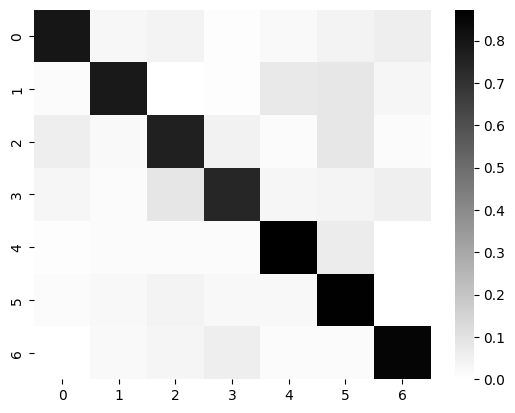

Initializing Kfold 2
Train shape: (3627, 2)
Test shape: (907, 2)
Found 3627 validated image filenames belonging to 7 classes.
Found 725 validated image filenames belonging to 7 classes.
Found 907 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 patching_and_embedding_5 (P  (None, 197, 192)         185664    
 atchingAndEmbedding)                                            
                                                                 
 dropout_5 (Dropout)         (None, 197, 192)          0         
                                                                 
 transformer_encoder_60 (Tra  (None, 197, 192)         444864    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_61 (Tra  (None, 197, 192)         444

<ipython-input-13-c745ba16ed14>:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/40
241/241 [==============================] - ETA: 0s - loss: 1.6175 - categorical_accuracy: 0.6260 - f1_m: 0.6086
Epoch 1: val_categorical_accuracy improved from -inf to 0.76828, saving model to /content/drive/MyDrive/Audiodata/grayTT_wts.hdf5
241/241 [==============================] - 117s 312ms/step - loss: 1.6175 - categorical_accuracy: 0.6260 - f1_m: 0.6086 - val_loss: 0.9358 - val_categorical_accuracy: 0.7683 - val_f1_m: 0.7200
Epoch 2/40
241/241 [==============================] - ETA: 0s - loss: 0.8534 - categorical_accuracy: 0.7688 - f1_m: 0.7835
Epoch 2: val_categorical_accuracy improved from 0.76828 to 0.80276, saving model to /content/drive/MyDrive/Audiodata/grayTT_wts.hdf5
241/241 [==============================] - 74s 305ms/step - loss: 0.8534 - categorical_accuracy: 0.7688 - f1_m: 0.7835 - val_loss: 0.7244 - val_categorical_accuracy: 0.8028 - val_f1_m: 0.7697
Epoch 3/40
241/241 [==============================] - ETA: 0s - loss: 0.7505 - categorical_accuracy: 0.802

<ipython-input-13-c745ba16ed14>:98: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)


907/907 [==============================] - 22s 22ms/step
(907,)
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       123
           1       0.84      0.89      0.86       134
           2       0.87      0.78      0.82       140
           3       0.74      0.73      0.74       120
           4       0.89      0.88      0.88       122
           5       0.79      0.89      0.84       126
           6       0.86      0.88      0.87       142

    accuracy                           0.84       907
   macro avg       0.84      0.84      0.84       907
weighted avg       0.84      0.84      0.84       907



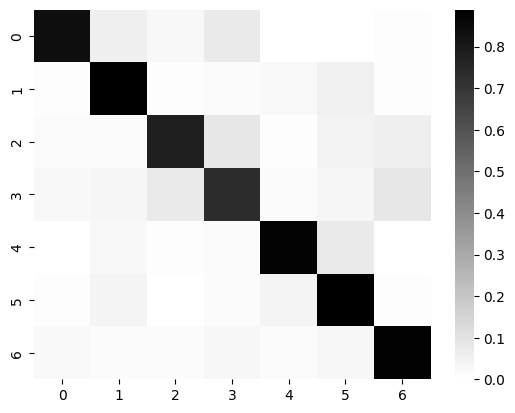

Initializing Kfold 3
Train shape: (3627, 2)
Test shape: (907, 2)
Found 3627 validated image filenames belonging to 7 classes.
Found 725 validated image filenames belonging to 7 classes.
Found 907 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 patching_and_embedding_6 (P  (None, 197, 192)         185664    
 atchingAndEmbedding)                                            
                                                                 
 dropout_6 (Dropout)         (None, 197, 192)          0         
                                                                 
 transformer_encoder_72 (Tra  (None, 197, 192)         444864    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_73 (Tra  (None, 197, 192)         444

<ipython-input-13-c745ba16ed14>:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/40
241/241 [==============================] - ETA: 0s - loss: 1.6191 - categorical_accuracy: 0.6019 - f1_m: 0.5912
Epoch 1: val_categorical_accuracy improved from -inf to 0.73655, saving model to /content/drive/MyDrive/Audiodata/grayTT_wts.hdf5
241/241 [==============================] - 119s 320ms/step - loss: 1.6191 - categorical_accuracy: 0.6019 - f1_m: 0.5912 - val_loss: 1.1856 - val_categorical_accuracy: 0.7366 - val_f1_m: 0.6924
Epoch 2/40
241/241 [==============================] - ETA: 0s - loss: 0.8593 - categorical_accuracy: 0.7647 - f1_m: 0.7777
Epoch 2: val_categorical_accuracy improved from 0.73655 to 0.79862, saving model to /content/drive/MyDrive/Audiodata/grayTT_wts.hdf5
241/241 [==============================] - 75s 310ms/step - loss: 0.8593 - categorical_accuracy: 0.7647 - f1_m: 0.7777 - val_loss: 0.8083 - val_categorical_accuracy: 0.7986 - val_f1_m: 0.7200
Epoch 3/40
241/241 [==============================] - ETA: 0s - loss: 0.7766 - categorical_accuracy: 0.787

<ipython-input-13-c745ba16ed14>:98: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)


907/907 [==============================] - 23s 24ms/step
(907,)
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       115
           1       0.81      0.93      0.87       125
           2       0.85      0.86      0.86       129
           3       0.74      0.84      0.79       128
           4       0.94      0.89      0.91       123
           5       0.89      0.83      0.86       150
           6       0.94      0.84      0.89       137

    accuracy                           0.86       907
   macro avg       0.86      0.86      0.86       907
weighted avg       0.87      0.86      0.86       907



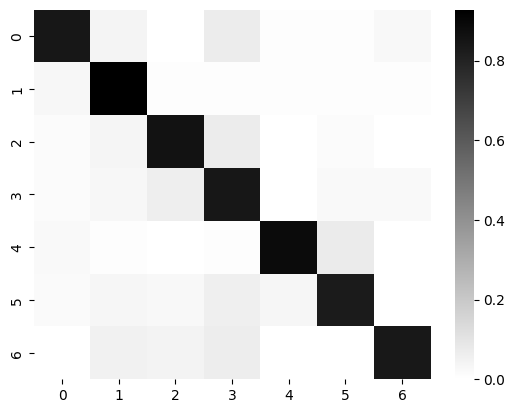

Initializing Kfold 4
Train shape: (3627, 2)
Test shape: (907, 2)
Found 3627 validated image filenames belonging to 7 classes.
Found 725 validated image filenames belonging to 7 classes.
Found 907 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 patching_and_embedding_7 (P  (None, 197, 192)         185664    
 atchingAndEmbedding)                                            
                                                                 
 dropout_7 (Dropout)         (None, 197, 192)          0         
                                                                 
 transformer_encoder_84 (Tra  (None, 197, 192)         444864    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_85 (Tra  (None, 197, 192)         444

<ipython-input-13-c745ba16ed14>:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/40
241/241 [==============================] - ETA: 0s - loss: 1.6592 - categorical_accuracy: 0.6276 - f1_m: 0.6349
Epoch 1: val_categorical_accuracy improved from -inf to 0.74207, saving model to /content/drive/MyDrive/Audiodata/grayTT_wts.hdf5
241/241 [==============================] - 119s 320ms/step - loss: 1.6592 - categorical_accuracy: 0.6276 - f1_m: 0.6349 - val_loss: 0.9494 - val_categorical_accuracy: 0.7421 - val_f1_m: 0.6979
Epoch 2/40
241/241 [==============================] - ETA: 0s - loss: 0.8246 - categorical_accuracy: 0.7749 - f1_m: 0.7899
Epoch 2: val_categorical_accuracy improved from 0.74207 to 0.80828, saving model to /content/drive/MyDrive/Audiodata/grayTT_wts.hdf5
241/241 [==============================] - 74s 306ms/step - loss: 0.8246 - categorical_accuracy: 0.7749 - f1_m: 0.7899 - val_loss: 0.7373 - val_categorical_accuracy: 0.8083 - val_f1_m: 0.7697
Epoch 3/40
241/241 [==============================] - ETA: 0s - loss: 0.7146 - categorical_accuracy: 0.805

<ipython-input-13-c745ba16ed14>:98: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)


907/907 [==============================] - 22s 22ms/step
(907,)
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       125
           1       0.88      0.82      0.85       143
           2       0.75      0.82      0.79       125
           3       0.85      0.76      0.80       152
           4       0.89      0.87      0.88       119
           5       0.77      0.82      0.79       122
           6       0.87      0.92      0.89       121

    accuracy                           0.84       907
   macro avg       0.84      0.84      0.84       907
weighted avg       0.84      0.84      0.84       907



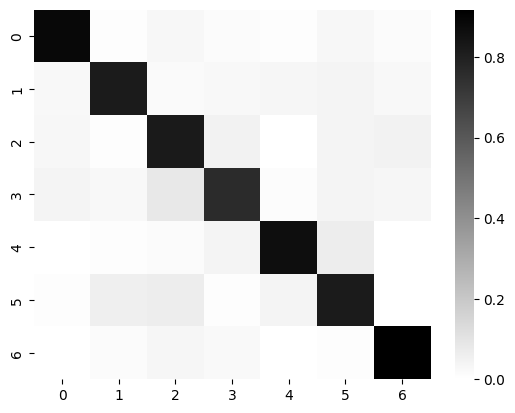

Initializing Kfold 5
Train shape: (3628, 2)
Test shape: (906, 2)
Found 3628 validated image filenames belonging to 7 classes.
Found 725 validated image filenames belonging to 7 classes.
Found 906 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 patching_and_embedding_8 (P  (None, 197, 192)         185664    
 atchingAndEmbedding)                                            
                                                                 
 dropout_8 (Dropout)         (None, 197, 192)          0         
                                                                 
 transformer_encoder_96 (Tra  (None, 197, 192)         444864    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_97 (Tra  (None, 197, 192)         444

<ipython-input-13-c745ba16ed14>:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/40
241/241 [==============================] - ETA: 0s - loss: 1.5720 - categorical_accuracy: 0.6263 - f1_m: 0.6260
Epoch 1: val_categorical_accuracy improved from -inf to 0.79724, saving model to /content/drive/MyDrive/Audiodata/grayTT_wts.hdf5
241/241 [==============================] - 118s 317ms/step - loss: 1.5720 - categorical_accuracy: 0.6263 - f1_m: 0.6260 - val_loss: 0.8971 - val_categorical_accuracy: 0.7972 - val_f1_m: 0.7366
Epoch 2/40
241/241 [==============================] - ETA: 0s - loss: 0.8160 - categorical_accuracy: 0.7783 - f1_m: 0.7894
Epoch 2: val_categorical_accuracy improved from 0.79724 to 0.84138, saving model to /content/drive/MyDrive/Audiodata/grayTT_wts.hdf5
241/241 [==============================] - 73s 303ms/step - loss: 0.8160 - categorical_accuracy: 0.7783 - f1_m: 0.7894 - val_loss: 0.6714 - val_categorical_accuracy: 0.8414 - val_f1_m: 0.7614
Epoch 3/40
241/241 [==============================] - ETA: 0s - loss: 0.7573 - categorical_accuracy: 0.792

<ipython-input-13-c745ba16ed14>:98: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)


906/906 [==============================] - 24s 24ms/step
(906,)
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       146
           1       0.83      0.87      0.85       116
           2       0.76      0.90      0.82       130
           3       0.83      0.81      0.82       138
           4       0.87      0.90      0.88       137
           5       0.87      0.76      0.81       130
           6       0.92      0.83      0.87       109

    accuracy                           0.85       906
   macro avg       0.85      0.85      0.85       906
weighted avg       0.85      0.85      0.85       906



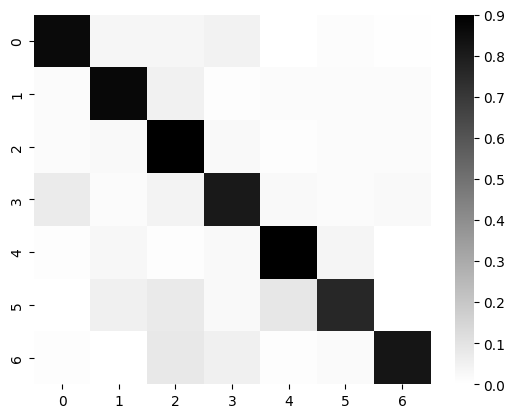

In [13]:
epochs = 40
i = 1
df_metrics = pd.DataFrame()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for train_index, test_index in kf.split(df_large, id):
    trainData = df_large.iloc[train_index]
    testData = df_large.iloc[test_index]
    print('Initializing Kfold %s'%str(i))
    print('Train shape:',trainData.shape)
    print('Test shape:',testData.shape)
    

    train_datagen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip = False, 
                                      vertical_flip = False, 
                                      #height_shift_range= 0.15, 
                                      width_shift_range=0.25,
                                      #zoom_range=0.8,
                                      zca_whitening=True,
                                      fill_mode="reflect",
                                      #channel_shift_range=100,
                                      validation_split=0.20)
    test_datagen = ImageDataGenerator(rescale=1. / 255) 

    train_generator=train_datagen.flow_from_dataframe(
                dataframe=trainData,
                directory="./",
                x_col="id",
                y_col="label",
                batch_size=batch_size,
                #color_mode="grayscale",
                shuffle=True,
                class_mode="categorical",
                seed=42,
                target_size=(IMG_HEIGHT, IMG_WIDTH))

    valid_generator=train_datagen.flow_from_dataframe(
                dataframe=trainData,
                directory="./",
                x_col="id",
                y_col="label",
                batch_size=1,
                #color_mode="grayscale",
                shuffle=False,
                class_mode="categorical",
                seed=42,
                subset="validation",
                target_size=(IMG_HEIGHT, IMG_WIDTH))
        
    test_generator=test_datagen.flow_from_dataframe(
                dataframe=testData,
                directory="./",
                x_col="id",
                y_col="label",
                #color_mode="grayscale",
                batch_size=1,
                shuffle=False,
                class_mode="categorical",
                target_size=(IMG_HEIGHT, IMG_WIDTH))

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size 

    #model = define_model()
    #model.summary()
    #model.load_weights('D:/emotion_audio/kfold/k_gray'+str(i)+'_wts.hdf5')
    model = get_model()
    model.summary()
    total_steps = 3627*10
    decay_steps = total_steps * 1.0

    cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
        1e-4, decay_steps, alpha=0.1
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_decay_scheduler),
        loss=dice_crossentropy,
        metrics=['categorical_accuracy', f1_m],
    )

    if i==1: 
      model.load_weights('/content/drive/MyDrive/Audiodata/grayTT_wts.hdf5')
    else:
      model.fit_generator(generator=train_generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=valid_generator,
                validation_steps=STEP_SIZE_VALID,
                epochs=epochs, callbacks=callbacks, verbose = 1)


    
    mcp_save = ModelCheckpoint('/content/drive/MyDrive/Audiodata/grayTT_wts.hdf5', save_best_only=True, verbose=1, monitor='val_categorical_accuracy', mode='max') 
    callbacks = [mcp_save]#,
    shutil.copy('/content/drive/MyDrive/Audiodata/grayTT_wts.hdf5','/content/drive/MyDrive/Audiodata/Rez_ViTTiny16/k_gray'+str(i)+'_wts.hdf5')
    model.load_weights('/content/drive/MyDrive/Audiodata/grayTT_wts.hdf5')
    y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    print(y_pred.shape)
    report = classification_report(test_generator.classes, y_pred, output_dict=True)
    classification_report_csv(report,i)
    print(classification_report(test_generator.classes, y_pred))

    ax = sns.heatmap(confusion_matrix(test_generator.classes, y_pred,normalize='true'), annot=False, cmap="gist_yarg")
    plt.show(block=False)
    ax.figure.savefig('/content/drive/MyDrive/Audiodata/Rez_ViTTiny16/confusion_matrix_n'+str(i)+'_.png')

    plt.pause(3)
    plt.close()    
    
    i+=1

In [14]:
df1=pd.read_csv('/content/drive/MyDrive/Audiodata/Rez_ViTTiny16/k_classification_report_'+str(1)+'_.csv')
df2=pd.read_csv('/content/drive/MyDrive/Audiodata/Rez_ViTTiny16/k_classification_report_'+str(2)+'_.csv')
df3=pd.read_csv('/content/drive/MyDrive/Audiodata/Rez_ViTTiny16/k_classification_report_'+str(3)+'_.csv')
df4=pd.read_csv('/content/drive/MyDrive/Audiodata/Rez_ViTTiny16/k_classification_report_'+str(4)+'_.csv')
df5=pd.read_csv('/content/drive/MyDrive/Audiodata/Rez_ViTTiny16/k_classification_report_'+str(5)+'_.csv')
mean5=np.dstack((df1.values,df2.values,df3.values,df4.values,df5.values)).mean(axis=2)
std5=np.dstack((df1.values,df2.values,df3.values,df4.values,df5.values)).std(axis=2)
print('mean=  \n', 100*np.dstack((df1.values,df2.values,df3.values,df4.values,df5.values))[:,0:3].mean(axis=2).round(4))
print('std= \n' , 100*np.dstack((df1.values,df2.values,df3.values,df4.values,df5.values))[:,0:3].std(axis=2).round(4))

mean=  
 [[88.37 84.55 86.39]
 [84.28 85.79 84.88]
 [80.32 82.48 81.2 ]
 [79.59 77.88 78.59]
 [88.05 87.99 87.97]
 [80.47 83.31 81.57]
 [88.67 86.36 87.38]
 [83.97 83.97 83.97]
 [84.25 84.05 84.  ]
 [84.32 83.97 83.99]]
std= 
 [[1.57 3.06 1.94]
 [2.37 5.09 1.64]
 [4.99 5.12 3.08]
 [4.48 4.23 2.83]
 [4.14 1.12 2.29]
 [6.46 4.41 2.68]
 [3.71 3.24 1.45]
 [1.64 1.64 1.64]
 [1.7  1.62 1.67]
 [1.67 1.64 1.66]]
